# Import necessary settings and modules

In [1]:
import findspark
findspark.init()

In [23]:
import pyspark
from pyspark.sql import SparkSession, functions as F, types as T
import pandas as pd
import os
import sys
import json
import matplotlib.pyplot as plt
%matplotlib inline

spark = SparkSession.builder.appName('YELP').getOrCreate()
sc = spark.sparkContext

# Loading Data

In [24]:
df_business = spark.read.json(os.getcwd()+'/yelp_dataset/yelp_academic_dataset_business.json')
df_business.columns

['address',
 'attributes',
 'business_id',
 'categories',
 'city',
 'hours',
 'is_open',
 'latitude',
 'longitude',
 'name',
 'postal_code',
 'review_count',
 'stars',
 'state']

In [26]:
df_business.select('state').show()

+-----+
|state|
+-----+
|   NC|
|   AZ|
|   QC|
|   NV|
|   AZ|
|   AZ|
|   NV|
|   AZ|
|   IL|
|   ON|
|   AB|
|   PA|
|   WI|
|   AZ|
|   NV|
|   NV|
|   NV|
|   AZ|
|   SC|
|   AZ|
+-----+
only showing top 20 rows



In [4]:
print(df_business.count())

209393


In [6]:
# df_business.select(['attributes','business_id', 'categories', 'city', 'name', 'review_count', 'stars']).show()
# df_business.select(['categories']).show(1)
df_business_catlist = df_business.select('categories').collect()

In [11]:
df_business_catlist

[Row(categories='Active Life, Gun/Rifle Ranges, Guns & Ammo, Shopping'),
 Row(categories='Health & Medical, Fitness & Instruction, Yoga, Active Life, Pilates'),
 Row(categories='Pets, Pet Services, Pet Groomers'),
 Row(categories='Hardware Stores, Home Services, Building Supplies, Home & Garden, Shopping'),
 Row(categories='Home Services, Plumbing, Electricians, Handyman, Contractors'),
 Row(categories='Auto Repair, Automotive, Oil Change Stations, Transmission Repair'),
 Row(categories='Dry Cleaning & Laundry, Local Services, Laundry Services'),
 Row(categories='Auto Repair, Oil Change Stations, Automotive, Tires'),
 Row(categories='Ethnic Food, Food Trucks, Specialty Food, Imported Food, Argentine, Food, Restaurants, Empanadas'),
 Row(categories='Martial Arts, Gyms, Fitness & Instruction, Active Life'),
 Row(categories='Contractors, Landscaping, Home Services'),
 Row(categories='Automotive, Auto Repair'),
 Row(categories='Desserts, Food, Ice Cream & Frozen Yogurt'),
 Row(categories='

In [32]:
# keep reviews
df_review = spark.read.json(os.getcwd()+'/yelp_dataset/yelp_academic_dataset_review.json')
df_review.columns

['business_id',
 'cool',
 'date',
 'funny',
 'review_id',
 'stars',
 'text',
 'useful',
 'user_id']

In [59]:
print(df_review.count())

432479


In [28]:
# keep users
df_user = spark.read.json(os.getcwd()+'/yelp_dataset/yelp_academic_dataset_user.json')
df_user.columns

['average_stars',
 'compliment_cool',
 'compliment_cute',
 'compliment_funny',
 'compliment_hot',
 'compliment_list',
 'compliment_more',
 'compliment_note',
 'compliment_photos',
 'compliment_plain',
 'compliment_profile',
 'compliment_writer',
 'cool',
 'elite',
 'fans',
 'friends',
 'funny',
 'name',
 'review_count',
 'useful',
 'user_id',
 'yelping_since']

In [60]:
print(df_user.count())

432479


# Filter Rows and Columns

Our dataset contains many columns, and most of them won’t be used in this project. From the table df_business, we want only the essential features of businesses such as the <b> id, name, stars, category and so on </b>. We are exclusively interested in companies that are restaurants and in the city of Toronto. Therefore we apply the function filter in the columns city and category to enforce this restriction. From the table df_review, we want only the reviews from the selected table above. We use an inner join of df_review and df_business to eliminate all other businesses from the table reviews.

In [20]:
df_business = df_business.select("business_id","name", "stars", 
                                 "review_count", "attributes", 
                                 "categories", "state", "city").withColumnRenamed("stars", "stars_restaurant")

df_business = df_business.filter((df_business['state'] == 'ON') & (df_business.categories.contains('Restaurants'))
                                & (df_business['review_count'] > 0)).drop('state')

In [29]:
df_business.select('categories').count()

209393

In [30]:
df_business.count()

209393

In [ ]:
df_business.toPandas()['business_id'].unique()

In [31]:
df_business.write.parquet('output/business.parquet')

## Keeping only "restaurant" business data and other associated data on users and reviews

We reduced the business dataset to businesses that had “Restaurant” in the category (restaurants). After reducing the business dataset, we reduced our review dataset in two ways:

- Only including reviews for businesses that existed in the reduced business (restaurant) dataset
- Only including reviews for users that have at least 2 reviews (A single rating does not help determine similarities between restaurants)

In [33]:
df_review = df_review.select('review_id','user_id', 'business_id', 'stars')
# df_review = df_review.join(df_business, on='business_id', how='inner')

In [37]:
# df_review.select['business_id'].unique
df_review.toPandas()['business_id'].unique()

Py4JJavaError: An error occurred while calling o156.collectToPython.
: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.next(SparkPlan.scala:282)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.next(SparkPlan.scala:276)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.foreach(SparkPlan.scala:276)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeCollect$1.apply(SparkPlan.scala:298)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeCollect$1.apply(SparkPlan.scala:297)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:186)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:297)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply$mcI$sp(Dataset.scala:3195)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3192)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3192)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:3225)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3192)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)


In [38]:
df_user = df_user.select("user_id","name", "review_count")
df_user = df_user.filter(df_user['review_count'] > 0)
# df_user = df_user.join(df_review, on='user_id', how='inner'

In [40]:
# df_user.show()

In [45]:
# df_user.select(['business_id', 'user_id', 'stars', 'name', 'review_count']).show()

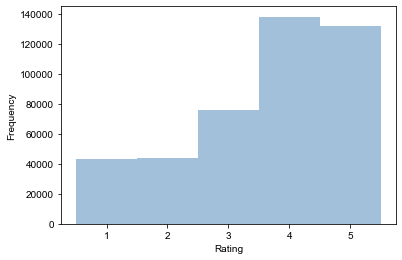

In [26]:
reviews = df_review.select('stars').collect()
review_list = [reviews[i][0] for i in range(len(reviews))]

plt.hist(review_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.style.use('seaborn-white')

Most ratings are above 3. Now let’s see the distribution of ratings of each restaurant.

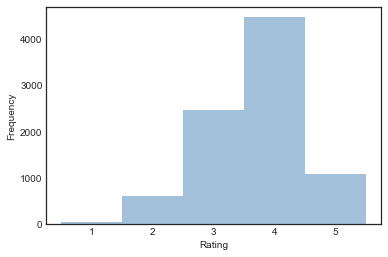

In [27]:
restaurant_reviews = df_business.select('stars_restaurant').collect()
restaurant_reviews_list = [restaurant_reviews[i][0] for i in range(len(restaurant_reviews))]


plt.hist(restaurant_reviews_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.style.use('seaborn-white')

Here were see a more normally distributed curve. Aditionally we can see that most restaurants do pretty well in terms of average rating. Now let’s visualise what the most popular type of restaurants in Toronto are. What kind of food do they serve? We will create a word cloud.

In [28]:
restaurant_categories = df_business.select('categories').collect()
restaurant_categories_list = [restaurant_categories[i][0] for i in range(len(restaurant_categories))]

In [29]:
text = " ".join(review for review in restaurant_categories_list)

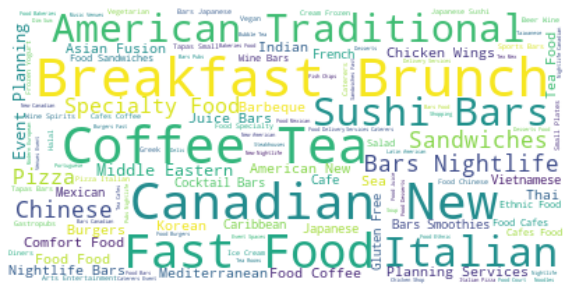

In [31]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# eliminate useless words
text = text.replace('Restaurants', "")
text = text.replace('bars', "")
text = text.replace('food', "")


# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()